# Graphical Models: Similarity Distribution Experimentation

In [31]:
# Import necessary libraries
import networkx as nx
import matplotlib.pyplot as plt
import random

## Similarity Implementations

### General Methods

In [2]:
# get all children in a dictionary including their respective weights (chains taken into account)
def get_all_children(graph, parent, children_dict={}, carry=1):
    weights = nx.get_edge_attributes(graph, 'weight')
    for i in graph.out_edges(parent):
        children_dict[i[1]] = carry*weights[i]
        get_all_children(graph, i[1], children_dict=children_dict, carry=weights[i])
    return children_dict

In [3]:
# (Adapted from function above)
# Get all children in a dictionary including their respective weights (chains taken into account)
def get_descendants(graph, parent, children_dict={}, carry=1):
    weights = nx.get_edge_attributes(graph, 'weight')
    
    for i in graph.out_edges(parent):
        children_dict[i[1]] = carry*weights[i]
        get_descendants(graph, i[1], children_dict=children_dict, carry=weights[i])
    
    return children_dict

In [4]:
# Returns children of a single node
def get_children(gm, parent):
    children_weights = {}
    weights = nx.get_edge_attributes(gm, 'weight')
    
    for i in gm.out_edges(parent):
        children_weights[i[1]] = weights[i]

    return children_weights

In [5]:
def find_node_children_subgraph(graph, snode, childgraph):
    cnodes = graph.neighbors(snode)
    edges = nx.edges(graph)
    for i in cnodes:
        childgraph.add_node(i)
        childgraph.add_edge(snode, i)
        childgraph = find_node_children_subgraph(graph, i, childgraph)
    return childgraph

### Jaccard Index

In [6]:
# all children of rain
def calculate_intersection(graph, children_a, children_b):
    inter = 0
    for i in children_a:
        if i in children_b:
            if children_a[i] < children_b[i]:
                inter += children_a[i]
            else:
                inter += children_b[i]
    return inter  

In [7]:
# helper func to calculate the union using method 1
def calculate_union_1(graph, children_a, children_b):
    union = 0
    for i in children_a:
        union += children_a[i]
    for i in children_b:
        union += children_b[i]
    union -= calculate_intersection(graph, children_a, children_b)
    return union

In [8]:
# helper func to calculate the union using method 2
def calculate_union_2(graph, children_a, children_b):
    union = 0
    for i in children_a:
        if i in children_b:
            union += abs(children_a[i] - children_b[i])
        else:
            union += children_a[i]
    for i in children_b:
        if not i in children_a:
            union += children_b[i]
    return union

In [9]:
# calculate the similarity, compares both methods
def calculate_similarity(graph, node_a, node_b):
    children_a = get_all_children(DG, node_a, {})
    children_b = get_all_children(DG, node_b, {})
    intersection = calculate_intersection(graph, children_a, children_b)
    union_1 = calculate_union_1(graph, children_a, children_b)
    union_2 = calculate_union_2(graph, children_a, children_b)
    results = {"method 1": intersection/union_1, "method 2": intersection/union_2}
    return results

### Edit-Distance

Edit-distance similarity implementation based only on a node's children.

In [10]:
# Returns the similarity of node B compared to node A, based on 
# children
def get_immediate_similarity(gm, A, B):
    cost = 0.0
    A_children = get_children(gm, A)
    B_children = get_children(gm, B)
    
    for child in A_children:
        if child in B_children:
            diff = abs(A_children[child] - B_children[child])
            cost += diff
        else:
            cost += 1
    
    return cost / len(A_children)

In [11]:
# Returns the node that is most similar to the input node
def find_most_immediate_similar(gm, A):
    nodes = list(gm.nodes)
    nodes.remove(A)
    
    max_similarity = get_immediate_similarity(gm, A, nodes[0])
    max_sim_node = nodes[0]
    for node in nodes:
        node_similarity = get_immediate_similarity(gm, A, node)
        
        if node_similarity < max_similarity:
            max_sim_node = node
            max_similarity = node_similarity
    
    return max_sim_node

Edit-distance similarity implementation based on all descendants of a node.

In [12]:
# Returns the similarity of node B compared to node A
def get_full_similarity(gm, A, B):
    cost = 0.0
    A_children = get_descendants(gm, A, {}, 1)
    B_children = get_descendants(gm, B, {}, 1)
    
    for child in A_children:
        if child in B_children:
            diff = abs(A_children[child] - B_children[child])
            cost += diff
        else:
            cost += 1
    return cost / len(A_children)

# Optional print line in for loop for debugging: 
# print(child, A_children[child], B_children[child])

In [32]:
# Returns the node that is most similar to the input node
def find_most_similar(gm, A):
    nodes = list(gm.nodes)
    nodes.remove(A)
    
    max_similarity = get_full_similarity(gm, A, nodes[0])
    max_sim_node = nodes[0]
    for node in nodes:
        node_similarity = get_full_similarity(gm, A, node)
        
        if node_similarity < max_similarity:
            max_sim_node = node
            max_similarity = node_similarity
    
    return max_sim_node

### NetworkX: Edit-Distance

In [33]:
# nx.graph_edit_distance(Graph1, Graph2)

### NetworkX: SimRank

In [34]:
# nx.algorithms.similarity.simrank_similarity(graph, source="node_a", target="node_b")

## Generating Random Directed Graphs

In [35]:
def addNodes(gm, num_nodes):
    node_list = []
    
    for i in range(num_nodes):
        gm.add_node(i)

    return gm

In [48]:
def addEdges(gm, num_nodes, num_edges):
    for i in range(num_edges):
        parent = random.randrange(num_nodes)
        child = random.randrange(num_nodes)
        
        while (child == parent):
            child = random.randrange(num_nodes)
        
        conditional_prob = random.uniform(0, 1)
        gm.add_edge(parent, child, weight=conditional_prob)
    
    return gm

In [49]:
def makeDirectedGraph(num_nodes, num_edges):
    dg = nx.DiGraph() # creates directed graph
    dg = addNodes(dg, num_nodes)
    dg = addEdges(dg, num_nodes, num_edges)
    return dg

In [91]:
def makeDirectedPath(num_nodes):
    pdg = nx.path_graph(num_nodes, create_using=nx.DiGraph())
    for i in pdg.edges():
        pdg.edges[i[0], i[1]]['weight'] = weight=random.uniform(0, 1)
    return pdg

In [106]:
def makeDirectedStarGraph(num_nodes):
    sdg = nx.DiGraph()
    sdg.add_node(0)
    for i in range(1, num_nodes+1):
        sdg.add_node(i)
        sdg.add_edge(0, i, weight=random.uniform(0, 1))
    return sdg

## Experiment

### make directed graph

In [92]:
g = makeDirectedGraph(3, 3)

In [93]:
nx.edges(g)

OutEdgeView([(0, 2), (0, 1), (1, 2)])

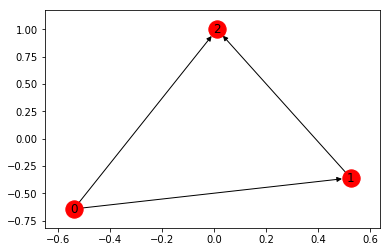

In [94]:
nx.draw_networkx(g)

In [95]:
nx.get_edge_attributes(g, 'weight')

{(0, 2): 0.12161287657906761,
 (0, 1): 0.4496120975444765,
 (1, 2): 0.6821197535768646}

### make directed path

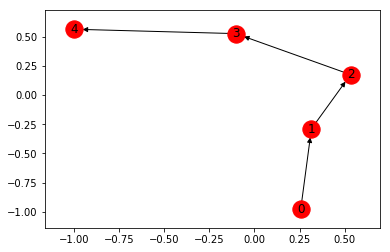

In [98]:
pdg = makeDirectedPath(5)
nx.draw_networkx(pdg)

In [99]:
nx.get_edge_attributes(pdg, 'weight')

{(0, 1): 0.3129067900216175,
 (1, 2): 0.7702221427726879,
 (2, 3): 0.3027811509567846,
 (3, 4): 0.27314865242218356}

### Star graph

In [107]:
sdg = makeDirectedStarGraph(5)

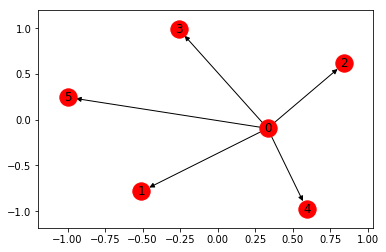

In [108]:
nx.draw_networkx(sdg)

### Random tree

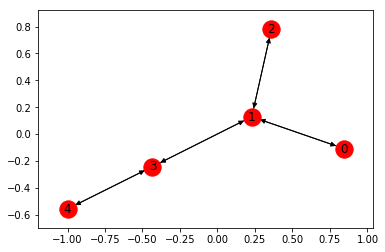

In [111]:
tg = nx.random_tree(5, seed=None)
nx.draw_networkx(tg.to_directed())